# Running predictions with newly trained model
While training is running in the other notebook, we can already start using the checkpoints (saved around every 10 minutes) to test the current model iteration on sample images.

In [2]:
%sh
#Download pet image dataset
set -x
mkdir -p $HOME/pet_data
cd $HOME/pet_data
curl -fsO http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
tar -xf images.tar.gz

+ mkdir -p /root/pet_data
+ cd /root/pet_data
+ curl -fsO http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
+ tar -xf images.tar.gz

# Imports

In [4]:
import numpy as np
import os
import random
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# Add library path to TensorFlow object detection module
sys.path.append("/opt/tensorflow/models/research")
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')

# Model preparation

## Convert latest training checkpoint to Frozen model

In [7]:
%sh
cd /opt/tensorflow/models/research
checkpoint_dir="$HOME/object_detection/inception"
rm -rf /dbfs/object_detection/inception/inference_graph
latest_checkpoint=$(basename "$(ls -t "$checkpoint_dir"/model.ckpt-*.meta | head -1)" .meta)
[[ -z "$latest_checkpoint" ]] && { echo "No checkpoint found in $checkpoint_dir" ; exit 1; }
echo "Using checkpoint: $latest_checkpoint"
PYTHONPATH=.:./slim /databricks/python/bin/python object_detection/export_inference_graph.py  \
  --input_type image_tensor \
  --pipeline_config_path /dbfs/object_detection/inception/object_detection.config \
  --trained_checkpoint_prefix "$checkpoint_dir/$latest_checkpoint" \
  --output_directory /dbfs/object_detection/inception/inference_graph

In [8]:
PATH_TO_FROZEN_GRAPH = '/dbfs/object_detection/inception/inference_graph/frozen_inference_graph.pb'
PATH_TO_LABELS = '/dbfs/object_detection/inception/data/pet_label_map.pbtxt'

## Load frozen Tensorflow model into memory.

In [10]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `beagle`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [12]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [14]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

While training is running on GPUs, we can use the CPUs to run prediction at small scale. If the GPUs are idle, it is recommended to use them as it greatly speeds up prediction.

In [16]:
# Set to false to use CPU instead of GPU to predict.
USE_GPU = False

In [17]:
# Load a few sample test images from VGG collection
NUM_IMAGES = 4
PATH_TO_TEST_IMAGES_DIR = '/root/pet_data/images'
all_images = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, i) for i in os.listdir(PATH_TO_TEST_IMAGES_DIR) if i.endswith(".jpg") ]
random.seed(1)
TEST_IMAGE_PATHS = random.sample(all_images, NUM_IMAGES)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [18]:
tf_config = None
if not USE_GPU:
  tf_config = tf.ConfigProto(device_count={'GPU': 0})
  
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session(config=tf_config) as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [19]:
#The score threshold to declare a detection, between 0 and 1.
SCORE_THRESHOLD = 0.5

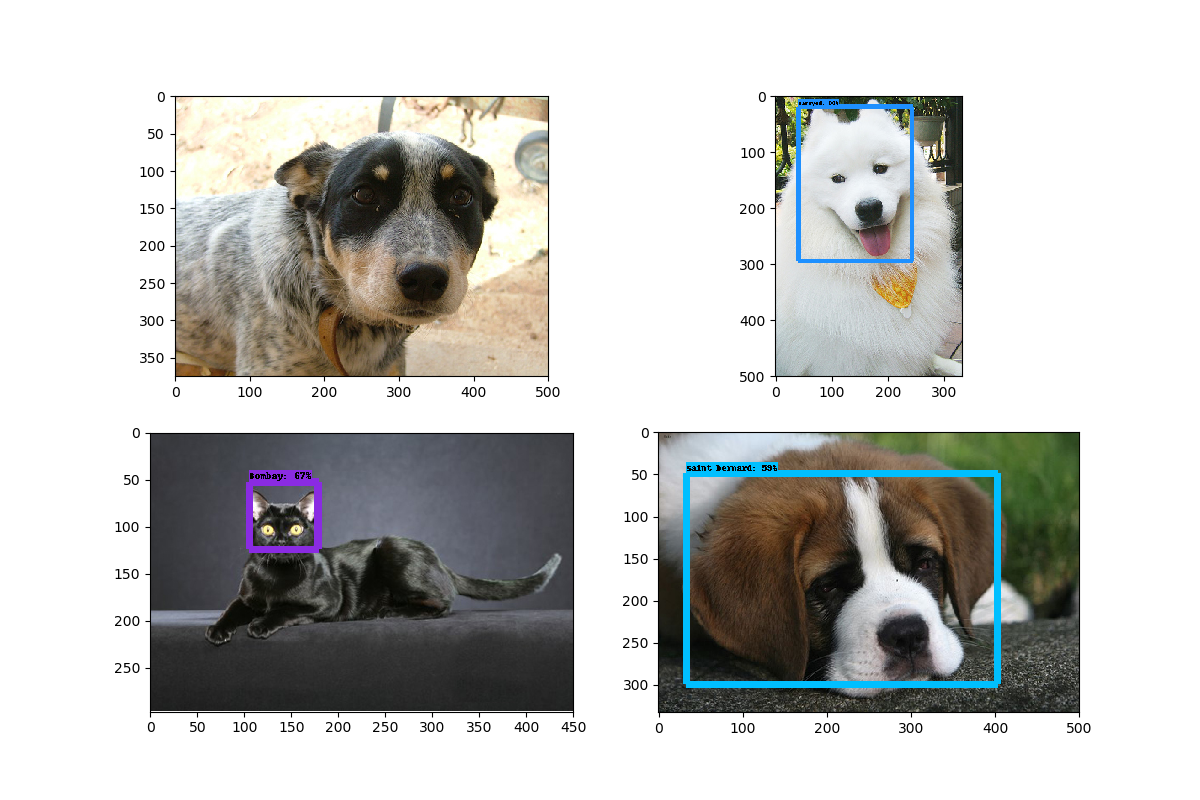

In [20]:
ncols = 2
import math
fig, axes = plt.subplots(math.ceil(len(TEST_IMAGE_PATHS) / ncols), ncols, squeeze=False, figsize=IMAGE_SIZE)
for ax_idx, image_path in enumerate(TEST_IMAGE_PATHS):
  col = ax_idx % ncols
  ax = axes[int((ax_idx - col)/ncols), col]
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      min_score_thresh=SCORE_THRESHOLD,
      line_thickness=8)
  ax.imshow(image_np)
display(fig)
